In [197]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
import numpy as np
import h5py as h5
from yt.utilities import cosmology as co

In [133]:
from matplotlib import rc, rcParams
rc('font', size=18)
rc('xtick', direction='in')
rc('ytick', direction='in')

In [134]:
fn = 'catalog.h5'
fp = h5.File(fn, 'r')
data = []
for g in fp:
    data.append({})
    for d in fp[g]:
        data[-1][d] = fp[g][d].value
fp.close()

In [135]:
data[0].keys()

[u'rvir',
 u'center',
 u'redshift',
 u'SFR',
 u'Mstar_pop3',
 u'Mstar_pop2',
 u'Mstar_pop2_young',
 u'fgas',
 u'Ntot',
 u'mass',
 u'NumberOfPop2Stars',
 u'NumberOfPop3Stars',
 u'fstar',
 u'Mstar',
 u'Nesc',
 u'fesc']

In [136]:
masses = np.zeros(len(data))
mstar = np.zeros(len(data))
for i,d in enumerate(data):
    masses[i] = data[i]['mass'][0]
    mstar[i] = data[i]['Mstar'][0]    

In [137]:
cos = co.Cosmology(omega_matter=0.266, omega_lambda=0.734, hubble_constant=0.71)

In [138]:
hmach = (masses >= 1e9) & (mstar > 1)
lmach = (masses >= 1e8) & (masses < 1e9) & (mstar > 1)

In [139]:
print hmach.sum(), lmach.sum()

8 145


In [140]:
def history_filter(mass, min_mass, max_decrease=0.1):
    n = mass.size
    # Only consider halos above the minimum mass
    fil = mass >= min_mass
    # Prune history of nodes that have mass decreases larger than some amount
    dM = np.zeros(n)
    last_good_mass = mass[-1]
    mass_filter = np.zeros(n, dtype=bool)
    for i in range(n-2,-1,-1):
        dM = (mass[i] - last_good_mass) / last_good_mass
        if dM > -max_decrease:
            last_good_mass = mass[i]
            mass_filter[i] = True
    fil = fil & mass_filter
    return fil

# HMACHs ($>10^9~M_\odot$)

In [183]:
def plot_halo_evo(data, xfield, yfield, min_mass=1e7,
                  median_highlight=False, mean_highlight=False, mean_weight=None,
                  yfilter=None, mfilter=None, remove=None, lw=3, alpha=1, 
                  fig=None, ax=None):
    n = len(data)
    sigma = [68.27, 95.45]
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(10,8))
    if mfilter is None:
        mfilter = np.ones(n, dtype='bool')
    if yfilter is None:
        yfilter = np.ones(n, dtype='bool')
    if remove is None:
        remove = []
    if median_highlight or mean_highlight:
        xunique = []
        nhalos = 0
    for i,halo in enumerate(data):
        if not mfilter[i]: continue
        if not yfilter[i]: continue
        if i in remove: continue
        fil = history_filter(halo['mass'], 1e7)
        if fil.sum() < 20: continue
        if xfield == "time":
            xdata = cos.t_from_z(halo['redshift'][fil]).in_units('Myr').v
        else:
            xdata = halo[xfield]
        #plt.semilogy(time, halo['mass'][good])
        ax.semilogy(xdata, halo[yfield][fil], lw=lw, alpha=alpha, label='Halo %d' % (i))
        if median_highlight or mean_highlight:
            xunique = np.concatenate([xunique, xdata])
            nhalos += 1
    if median_highlight or mean_highlight:
        xunique = np.unique(xunique)
        ydata = np.zeros((xunique.size, nhalos))
        if mean_weight is not None:
            yw = np.zeros((xunique.size, nhalos))
        count = 0
        # Interpolate to xunique values
        for i, halo in enumerate(data):
            if not mfilter[i]: continue
            if not yfilter[i]: continue
            if i in remove: continue
            fil = history_filter(halo['mass'], 1e7)
            if fil.sum() < 20: continue
            if xfield == "time":
                xd = cos.t_from_z(halo['redshift'][fil]).in_units('Myr').v
                xd = xd[::-1]
                if mean_weight is not None:
                    ym = halo[mean_weight][fil][::-1]
                yd = halo[yfield][fil][::-1]
                reverse = True
            else:
                xd = halo[xfield][fil]
                if mean_weight is not None:
                    ym = halo[mean_weight][fil]
                yd = halo[yfield][fil]
                reverse = False
            ydata[:,count] = np.interp(xunique, xd, yd, left=np.nan)
            if mean_weight is not None:
                yw[:,count] = np.interp(xunique, xd, ym, left=0)
            count += 1
        #if reverse:
        #    ydata = ydata[::-1,:]
        #ymed = np.median(ydata, axis=1)
        if median_highlight:
            ymed = np.nanpercentile(ydata, 50, axis=1, interpolation='midpoint')
            y1m = np.nanpercentile(ydata, 50-0.5*sigma[0], axis=1, interpolation='midpoint')
            y1p = np.nanpercentile(ydata, 50+0.5*sigma[0], axis=1, interpolation='midpoint')
            #y2m = np.nanpercentile(ydata, 50-0.5*sigma[1], axis=1, interpolation='midpoint')
            #y2p = np.nanpercentile(ydata, 50+0.5*sigma[1], axis=1, interpolation='midpoint')
            ax.semilogy(xunique, ymed, lw=5, c='k', alpha=0.5)
            ax.fill_between(xunique, y1m, y1p, facecolor='k', alpha=0.25)
            #ax.fill_between(xunique, y2m, y2p, facecolor='k', alpha=0.1)
        if mean_highlight:
            if mean_weight is None:
                ymean = np.nanmean(ydata, axis=1)
            else:
                #import pdb; pdb.set_trace()
                yw_sum = np.nansum(yw, axis=1)
                zeros = (np.abs(yw_sum) < 1e-20)
                nan = np.isnan(yw)
                yw[zeros, :] = 1.0
                yw[nan] = 0.0
                ymean = np.nansum(ydata * yw, axis=1) / np.nansum(yw, axis=1)
                #ymean = np.average(ydata, axis=1, weights=yw)
                #import pdb; pdb.set_trace()
            ax.semilogy(xunique, ymean, lw=5, c='k', alpha=0.5, ls='--')
    return fig, ax

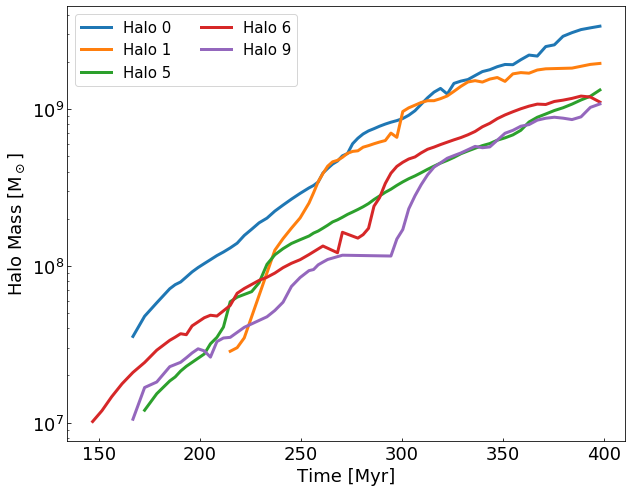

In [142]:
remove = [67, 234, 256]
fig, ax = plot_halo_evo(data, 'time', 'mass', min_mass=1e7, mfilter=hmach, remove=remove)
                        #median_highlight=True, mean_highlight=True, mean_weight='Mstar')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'Halo Mass [M$_\odot$]')
ax.legend(loc='best', fontsize='small', ncol=2)
plt.show()

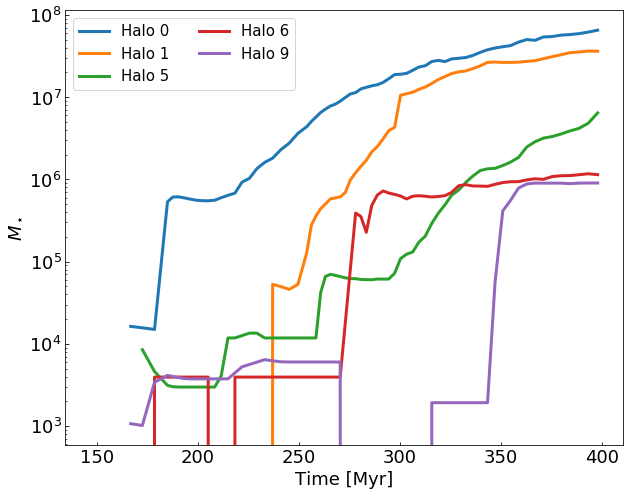

In [143]:
fig, ax = plot_halo_evo(data, 'time', 'Mstar', min_mass=1e7, mfilter=hmach, remove=remove)
ax.set_yscale('log')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'$M_\star$')
ax.legend(loc='best', fontsize='small', ncol=2)
plt.show()

Unsuccessful attempt at a semi-log-linear y-axis. There aren't enough data points to make a smooth transition between log and linear values of $f_{\rm esc}$.

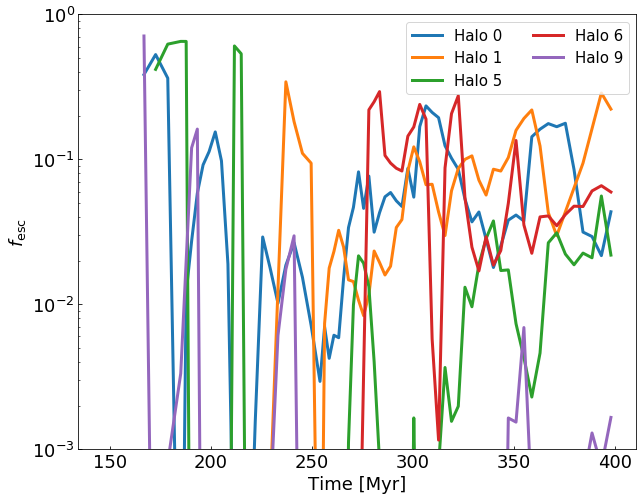

In [144]:
fig, ax = plot_halo_evo(data, 'time', 'fesc', min_mass=1e7, mfilter=hmach, remove=remove)
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'$f_{\rm esc}$')
ax.set_ylim(1e-3, 1)
ax.legend(loc='best', fontsize='small', ncol=2)
plt.show()

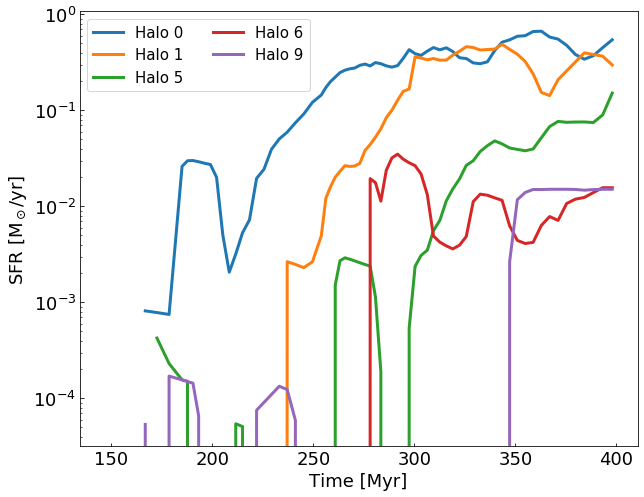

In [145]:
fig, ax = plot_halo_evo(data, 'time', 'SFR', min_mass=1e7, mfilter=hmach, remove=remove)
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'SFR [M$_\odot$/yr]')
ax.legend(loc='best', fontsize='small', ncol=2)
plt.show()

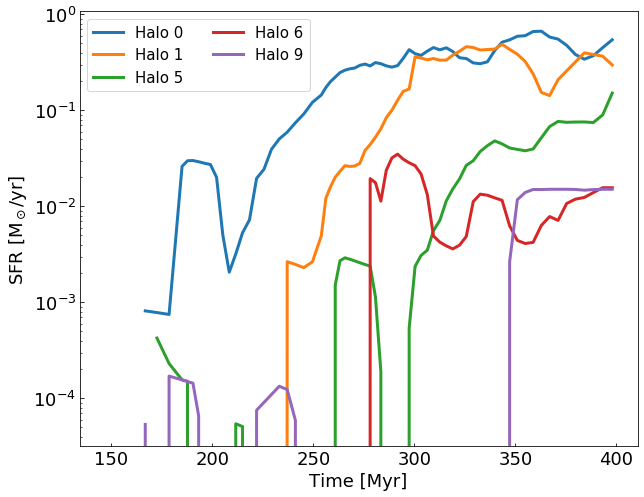

In [146]:
fig, ax = plot_halo_evo(data, 'time', 'SFR', min_mass=1e7, mfilter=hmach, remove=remove)
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'SFR [M$_\odot$/yr]')
ax.legend(loc='best', fontsize='small', ncol=2)
plt.show()

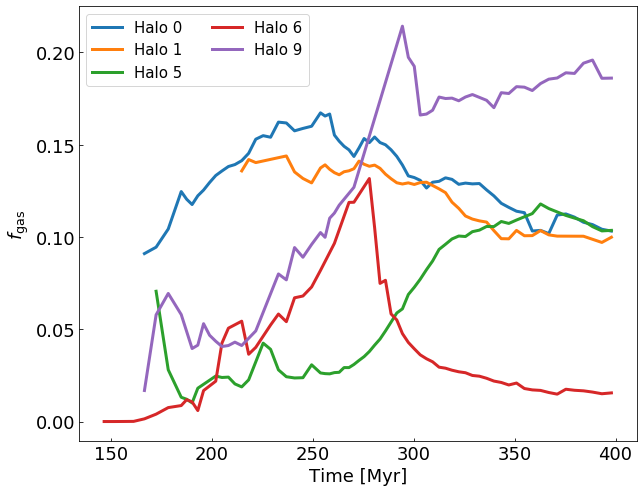

In [147]:
fig, ax = plot_halo_evo(data, 'time', 'fgas', min_mass=1e7, mfilter=hmach, remove=remove)
ax.set_yscale('linear')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'$f_{\rm gas}$')
ax.legend(loc='best', fontsize='small', ncol=2)
plt.show()

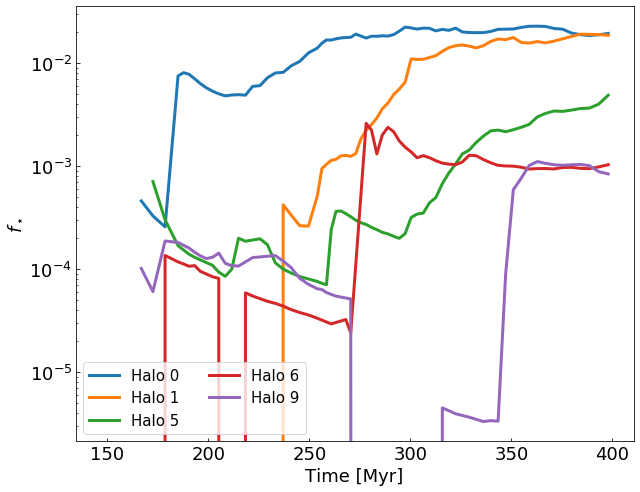

In [148]:
fig, ax = plot_halo_evo(data, 'time', 'fstar', min_mass=1e7, mfilter=hmach, remove=remove)
ax.set_yscale('log')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'$f_\star$')
ax.legend(loc='best', fontsize='small', ncol=2)
plt.show()

# LMACHs ($10^8 - 10^9~M_\odot$)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


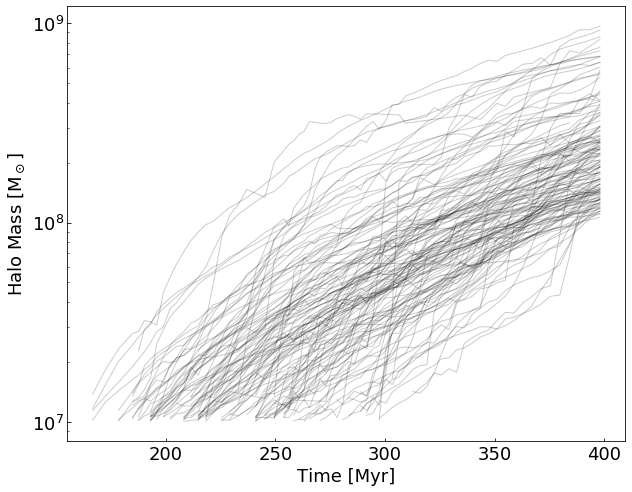

In [149]:
remove = []
fig, ax = plt.subplots(figsize=(10,8))
for i,halo in enumerate(data):
    if not lmach[i]: continue
    if i in remove: continue
    fil = history_filter(halo['mass'], 1e7)
    if fil.sum() < 20: continue
    time = cos.t_from_z(halo['redshift'][fil]).in_units('Myr').v
    #plt.semilogy(time, halo['mass'][good])
    ax.semilogy(time, halo['mass'][fil], lw=1, alpha=0.2, c='k', label='Halo %d' % (i))

ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'Halo Mass [M$_\odot$]')
#ax.legend(loc='best', fontsize='small', ncol=2)
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


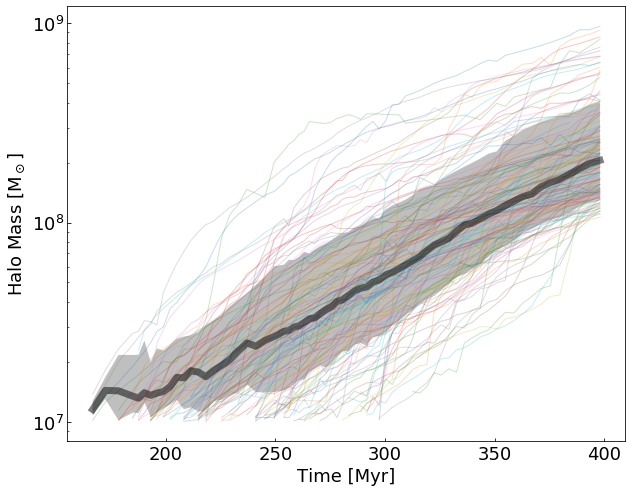

In [150]:
fig, ax = plot_halo_evo(data, 'time', 'mass', min_mass=1e7, mfilter=lmach, alpha=0.25, lw=1, median_highlight=True)
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'Halo Mass [M$_\odot$]')
plt.show()

In [151]:
fesc = np.zeros(len(data))
for i in range(len(data)):
    fesc[i] = data[i]['fesc'][0]

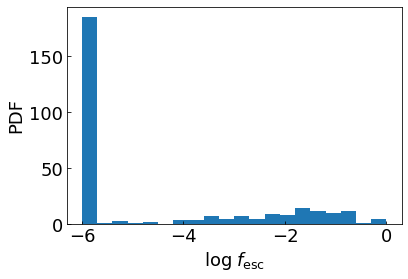

In [152]:
H = plt.hist(np.log10(fesc), bins=20, range=(-6, 0), normed=False)
plt.xlabel(r'$\log \; f_{\rm esc}$')
plt.ylabel('PDF');

In [153]:
high_fesc = (fesc >= 0.1)
mid_fesc = (fesc >= 0.01) & (fesc < 0.1)
low_fesc = (fesc < 0.01)

# Plotting all LMACHs

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


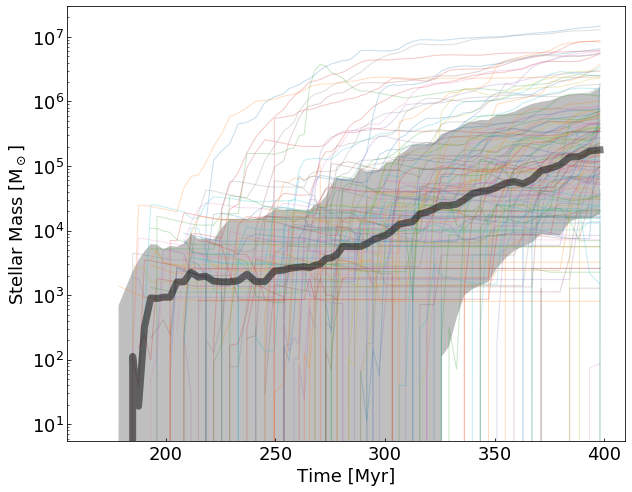

In [154]:
fig, ax = plot_halo_evo(data, 'time', 'Mstar', min_mass=1e7, mfilter=lmach, alpha=0.25, lw=1, median_highlight=True)
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'Stellar Mass [M$_\odot$]')
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


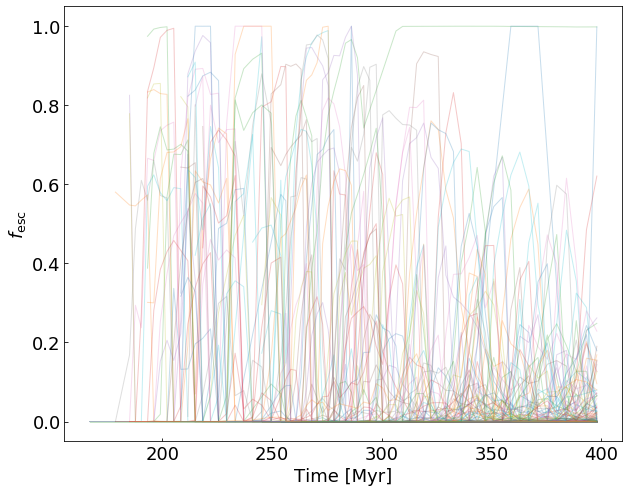

In [155]:
fig, ax = plot_halo_evo(data, 'time', 'fesc', min_mass=1e7, mfilter=lmach, alpha=0.25, lw=1)
ax.set_yscale('linear')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'$f_{\rm esc}$')
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


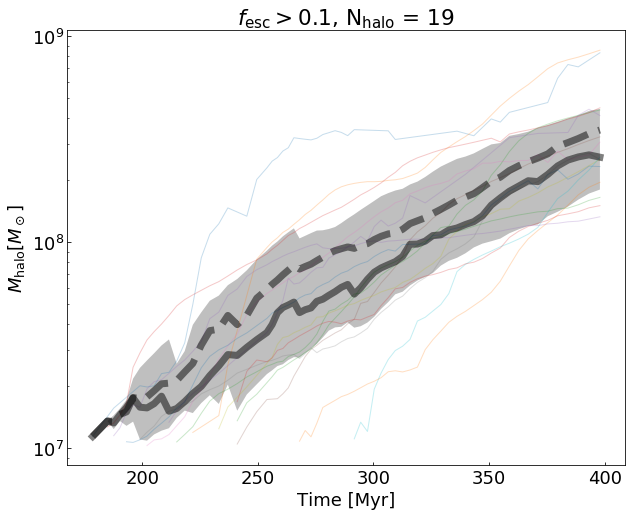

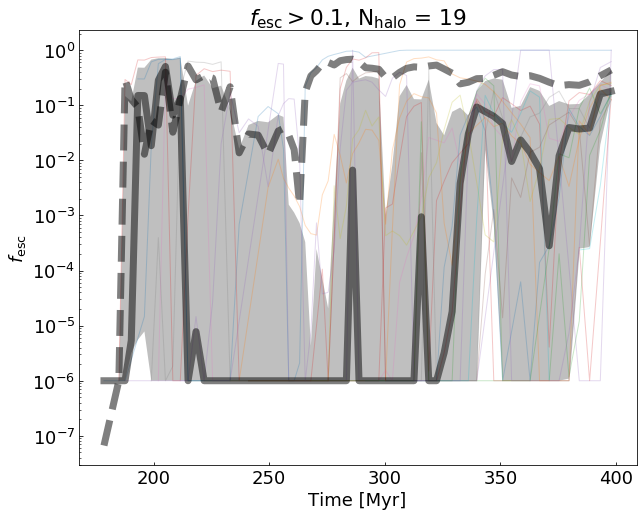

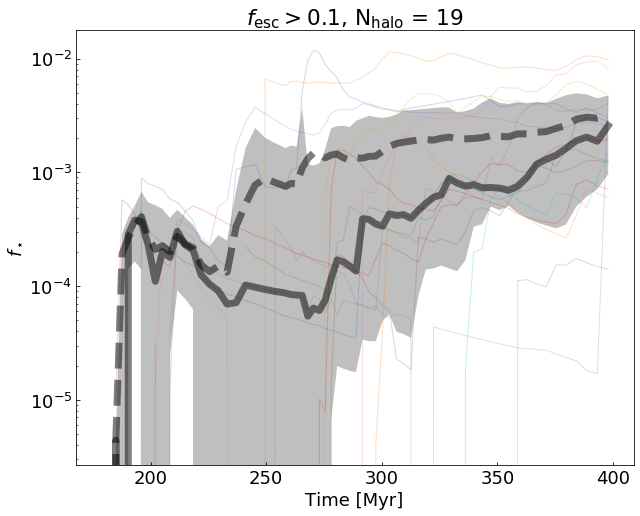

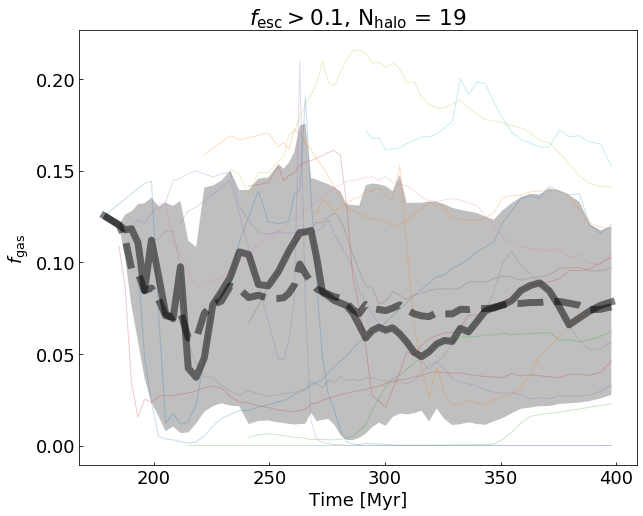

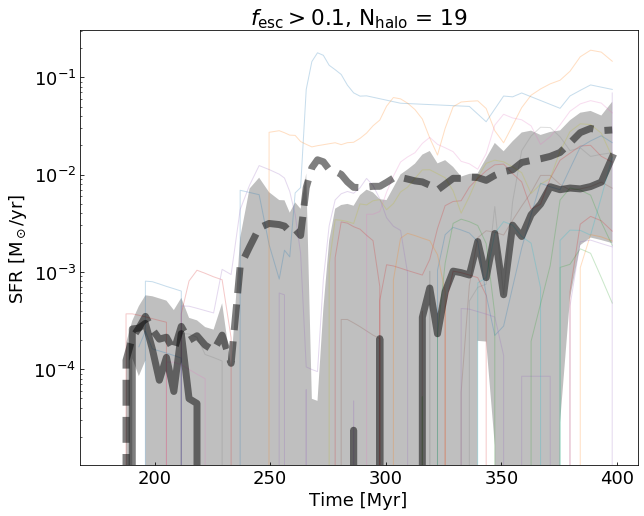

In [156]:
fig, ax = plot_halo_evo(data, 'time', 'mass', min_mass=1e7, mfilter=lmach, alpha=0.25, lw=1, yfilter=high_fesc,
                        median_highlight=True, mean_highlight=True, mean_weight=None)
ax.set_title(r'$f_{\rm esc} > 0.1$, N$_{\rm halo}$ = %d' % (high_fesc.sum()))
#ax.set_yscale('linear')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'$M_{\rm halo} [M_\odot]$')
plt.show()

fig, ax = plot_halo_evo(data, 'time', 'fesc', min_mass=1e7, mfilter=lmach, alpha=0.25, lw=1, yfilter=high_fesc,
                        median_highlight=True, mean_highlight=True, mean_weight='Ntot')
ax.set_title(r'$f_{\rm esc} > 0.1$, N$_{\rm halo}$ = %d' % (high_fesc.sum()))
#ax.set_yscale('linear')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'$f_{\rm esc}$')
plt.show()

fig, ax = plot_halo_evo(data, 'time', 'fstar', min_mass=1e7, mfilter=lmach, alpha=0.25, lw=1, yfilter=high_fesc,
                        median_highlight=True, mean_highlight=True, mean_weight=None)
ax.set_title(r'$f_{\rm esc} > 0.1$, N$_{\rm halo}$ = %d' % (high_fesc.sum()))
#ax.set_yscale('linear')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'$f_\star$')
plt.show()

fig, ax = plot_halo_evo(data, 'time', 'fgas', min_mass=1e7, mfilter=lmach, alpha=0.25, lw=1, yfilter=high_fesc,
                        median_highlight=True, mean_highlight=True, mean_weight=None)
ax.set_title(r'$f_{\rm esc} > 0.1$, N$_{\rm halo}$ = %d' % (high_fesc.sum()))
ax.set_yscale('linear')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'$f_{\rm gas}$')
plt.show()

fig, ax = plot_halo_evo(data, 'time', 'SFR', min_mass=1e7, mfilter=lmach, alpha=0.25, lw=1, yfilter=high_fesc,
                        median_highlight=True, mean_highlight=True, mean_weight=None)
ax.set_title(r'$f_{\rm esc} > 0.1$, N$_{\rm halo}$ = %d' % (high_fesc.sum()))
#ax.set_yscale('linear')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'SFR [M$_\odot$/yr]')
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


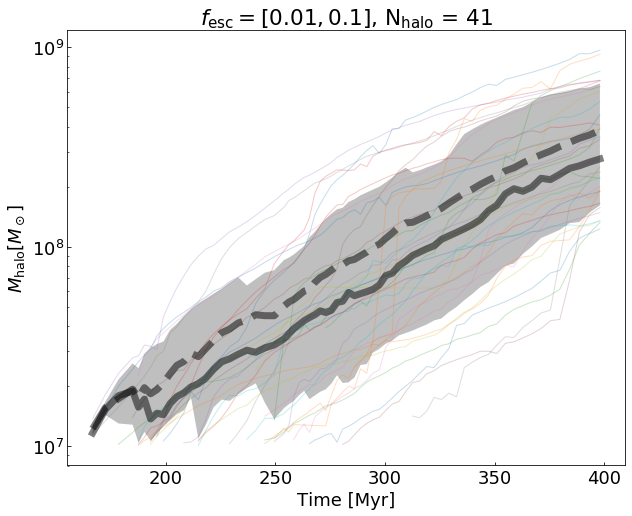

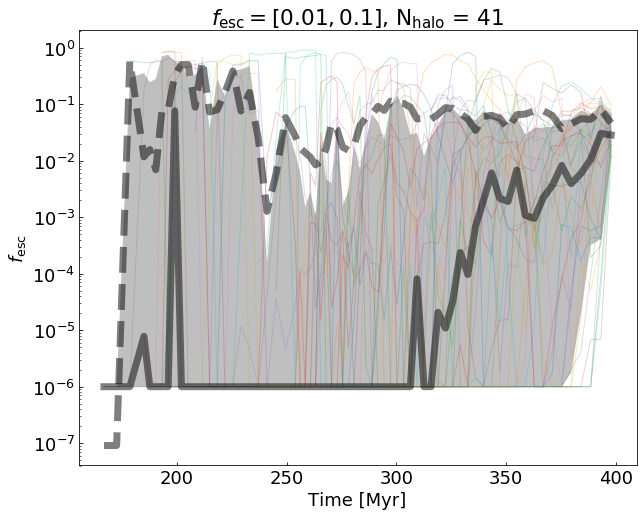

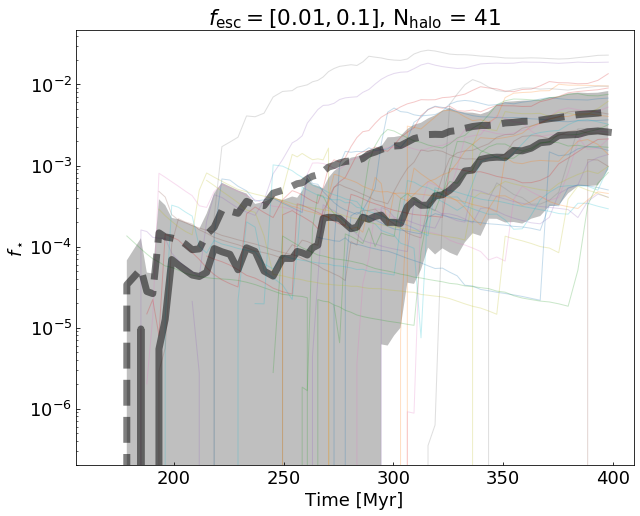

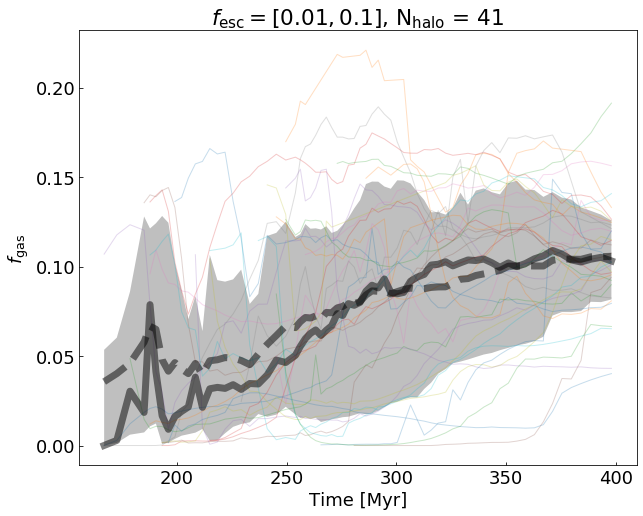

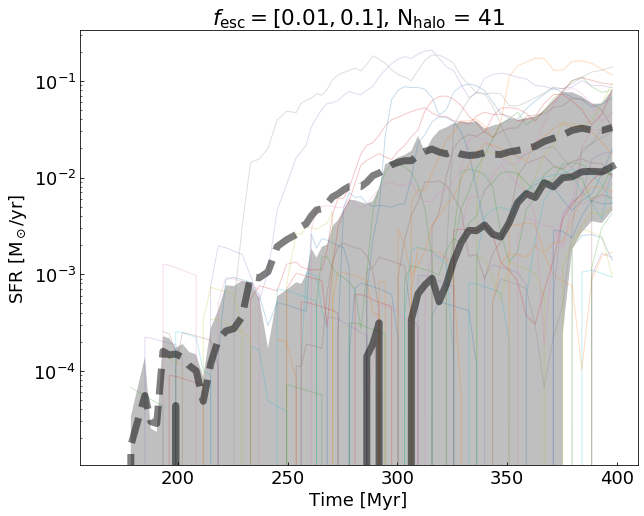

In [157]:
fig, ax = plot_halo_evo(data, 'time', 'mass', min_mass=1e7, mfilter=lmach, alpha=0.25, lw=1, yfilter=mid_fesc,
                        median_highlight=True, mean_highlight=True, mean_weight=None)
ax.set_title(r'$f_{\rm esc} = [0.01, 0.1]$, N$_{\rm halo}$ = %d' % (mid_fesc.sum()))
#ax.set_yscale('linear')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'$M_{\rm halo} [M_\odot]$')
plt.show()

fig, ax = plot_halo_evo(data, 'time', 'fesc', min_mass=1e7, mfilter=lmach, alpha=0.25, lw=1, yfilter=mid_fesc,
                        median_highlight=True, mean_highlight=True, mean_weight='Ntot')
ax.set_title(r'$f_{\rm esc} = [0.01, 0.1]$, N$_{\rm halo}$ = %d' % (mid_fesc.sum()))
#ax.set_yscale('linear')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'$f_{\rm esc}$')
plt.show()

fig, ax = plot_halo_evo(data, 'time', 'fstar', min_mass=1e7, mfilter=lmach, alpha=0.25, lw=1, yfilter=mid_fesc,
                        median_highlight=True, mean_highlight=True, mean_weight=None)
ax.set_title(r'$f_{\rm esc} = [0.01, 0.1]$, N$_{\rm halo}$ = %d' % (mid_fesc.sum()))
#ax.set_yscale('linear')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'$f_\star$')
plt.show()

fig, ax = plot_halo_evo(data, 'time', 'fgas', min_mass=1e7, mfilter=lmach, alpha=0.25, lw=1, yfilter=mid_fesc,
                        median_highlight=True, mean_highlight=True, mean_weight=None)
ax.set_title(r'$f_{\rm esc} = [0.01, 0.1]$, N$_{\rm halo}$ = %d' % (mid_fesc.sum()))
ax.set_yscale('linear')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'$f_{\rm gas}$')
plt.show()

fig, ax = plot_halo_evo(data, 'time', 'SFR', min_mass=1e7, mfilter=lmach, alpha=0.25, lw=1, yfilter=mid_fesc,
                        median_highlight=True, mean_highlight=True, mean_weight=None)
ax.set_title(r'$f_{\rm esc} = [0.01, 0.1]$, N$_{\rm halo}$ = %d' % (mid_fesc.sum()))
#ax.set_yscale('linear')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'SFR [M$_\odot$/yr]')
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


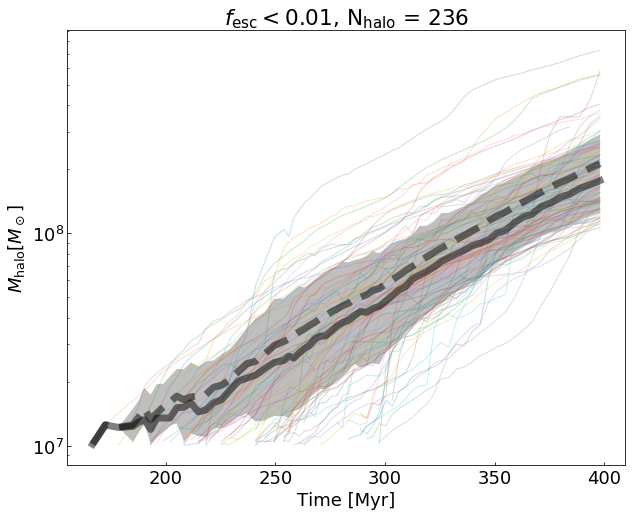

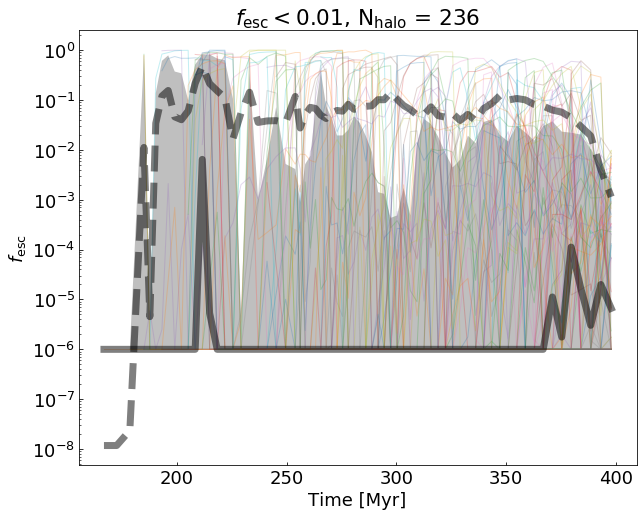

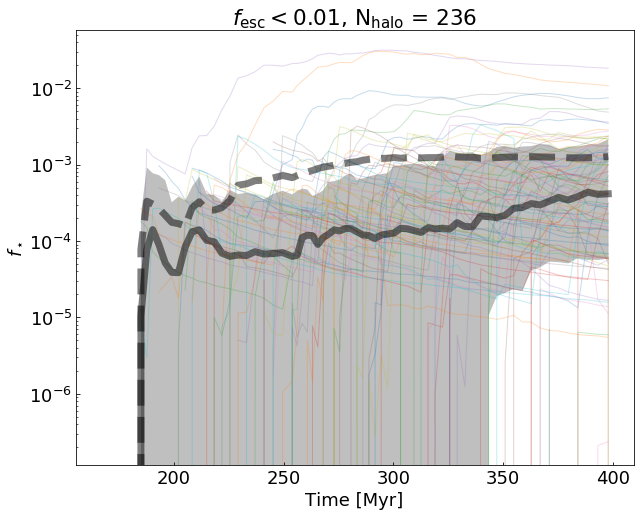

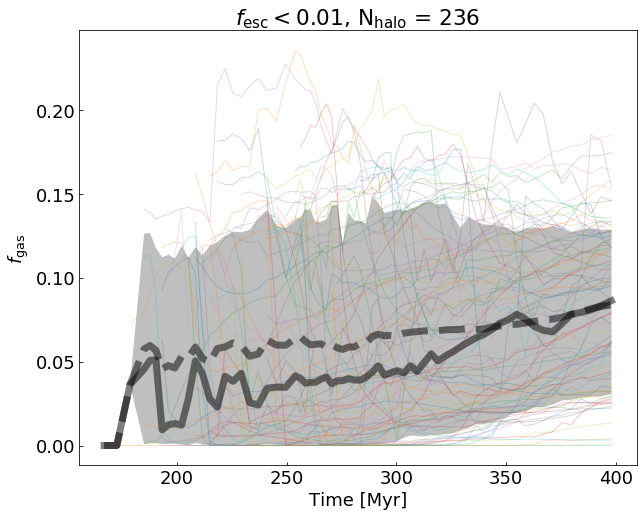

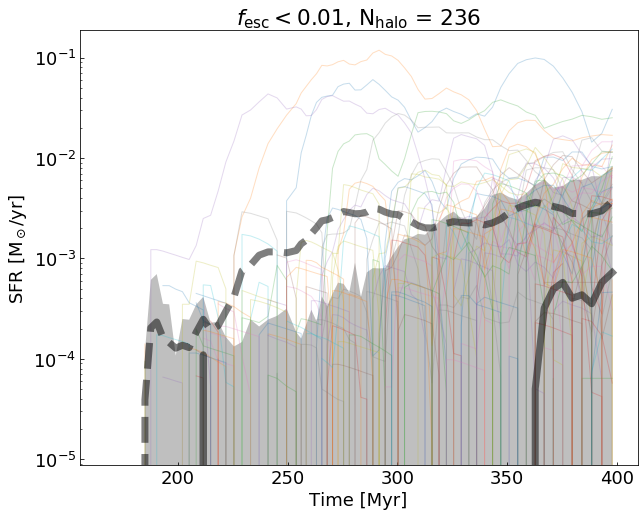

In [158]:
fig, ax = plot_halo_evo(data, 'time', 'mass', min_mass=1e7, mfilter=lmach, alpha=0.25, lw=1, yfilter=low_fesc,
                        median_highlight=True, mean_highlight=True, mean_weight=None)
ax.set_title(r'$f_{\rm esc} < 0.01$, N$_{\rm halo}$ = %d' % (low_fesc.sum()))
#ax.set_yscale('linear')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'$M_{\rm halo} [M_\odot]$')
plt.show()

fig, ax = plot_halo_evo(data, 'time', 'fesc', min_mass=1e7, mfilter=lmach, alpha=0.25, lw=1, yfilter=low_fesc,
                        median_highlight=True, mean_highlight=True, mean_weight='Ntot')
ax.set_title(r'$f_{\rm esc} < 0.01$, N$_{\rm halo}$ = %d' % (low_fesc.sum()))
#ax.set_yscale('linear')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'$f_{\rm esc}$')
plt.show()

fig, ax = plot_halo_evo(data, 'time', 'fstar', min_mass=1e7, mfilter=lmach, alpha=0.25, lw=1, yfilter=low_fesc,
                        median_highlight=True, mean_highlight=True, mean_weight=None)
ax.set_title(r'$f_{\rm esc} < 0.01$, N$_{\rm halo}$ = %d' % (low_fesc.sum()))
#ax.set_yscale('linear')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'$f_\star$')
plt.show()

fig, ax = plot_halo_evo(data, 'time', 'fgas', min_mass=1e7, mfilter=lmach, alpha=0.25, lw=1, yfilter=low_fesc,
                        median_highlight=True, mean_highlight=True, mean_weight=None)
ax.set_title(r'$f_{\rm esc} < 0.01$, N$_{\rm halo}$ = %d' % (low_fesc.sum()))
ax.set_yscale('linear')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'$f_{\rm gas}$')
plt.show()

fig, ax = plot_halo_evo(data, 'time', 'SFR', min_mass=1e7, mfilter=lmach, alpha=0.25, lw=1, yfilter=low_fesc,
                        median_highlight=True, mean_highlight=True, mean_weight=None)
ax.set_title(r'$f_{\rm esc} < 0.01$, N$_{\rm halo}$ = %d' % (low_fesc.sum()))
#ax.set_yscale('linear')
ax.set_xlabel('Time [Myr]')
ax.set_ylabel(r'SFR [M$_\odot$/yr]')
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


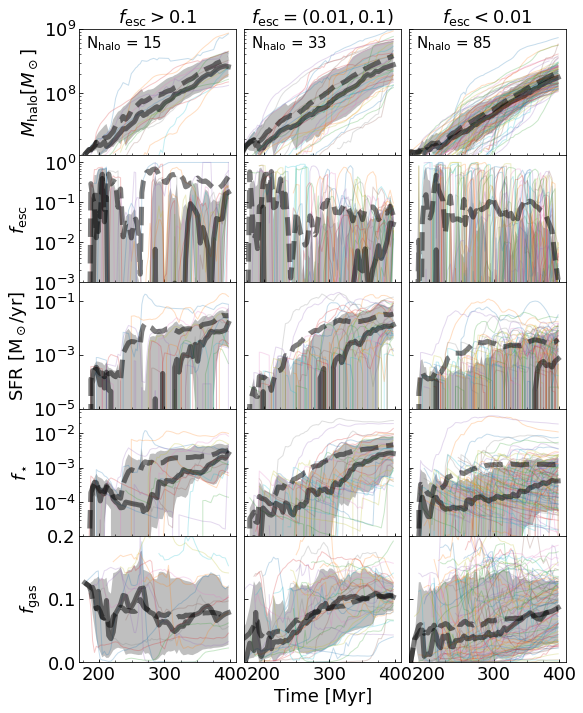

In [205]:
rc('font', size=18)
fig, ax = plt.subplots(5, 3, sharex=True, sharey=False, figsize=(8,10), squeeze=True)
plt.subplots_adjust(hspace=0, wspace=0.05, top=0.95, bottom=0.07, right=0.97)

xfield = 'time'
yfields = ['mass', 'fesc', 'SFR', 'fstar', 'fgas']
weights = [None, 'Ntot', None, None, None]

xr = (170, 410)
yr = dict(mass=(1.1e7, 1e9), fesc=(1e-3, 1.5), SFR=(1e-5, 0.5), fstar=(1.1e-5, 0.05), fgas=(0,0.2))
yscale = dict(mass='log', fesc='log', SFR='log', fstar='log', fgas='linear')

yfilters = [high_fesc, mid_fesc, low_fesc]
mfilter = lmach

xlabel = 'Time [Myr]'
ylabels = [r'$M_{\rm halo} [M_\odot]$', r'$f_{\rm esc}$', r'SFR [M$_\odot$/yr]', 
           r'$f_\star$', r'$f_{\rm gas}$']
xtitles = [r'$f_{\rm esc} > 0.1$', r'$f_{\rm esc} = (0.01,0.1)$',
           r'$f_{\rm esc} < 0.01$']

alpha = 0.25
lw = 1
min_mass = 1e7

for i, yf in enumerate(yfields):
    for j, yfil in enumerate(yfilters):
        fig, ax[i,j] = plot_halo_evo(data, xfield, yf, min_mass=min_mass, mfilter=mfilter, 
                                     alpha=alpha, lw=lw,
                                     yfilter=yfil, median_highlight=True,
                                     mean_highlight=True, mean_weight=weights[i],
                                     fig=fig, ax=ax[i,j])
        ax[i,j].set_yscale(yscale[yf])
        ax[i,j].set_ylim(yr[yf][0], yr[yf][1])
        ax[i,j].set_xlim(xr[0], xr[1])
        ax[i,j].label_outer()
        ax[i,j].xaxis.set_major_locator(ticker.MultipleLocator(100))
        ax[i,j].xaxis.set_minor_locator(ticker.MultipleLocator(25))
    ax[i,0].set_ylabel(ylabels[i])

for j in range(ax.shape[1]):
    ax[0,j].set_title(xtitles[j], fontsize='medium')
    nplots = len(ax[0,j].get_lines())-2
    ax[0,j].text(180, 5e8, r'N$_{\rm halo}$ = %d' % (nplots), fontsize='small')
ax[-1,1].set_xlabel(xlabel)

plt.savefig('fesc-lmach.png')
plt.savefig('fesc-lmach.pdf')
plt.show()

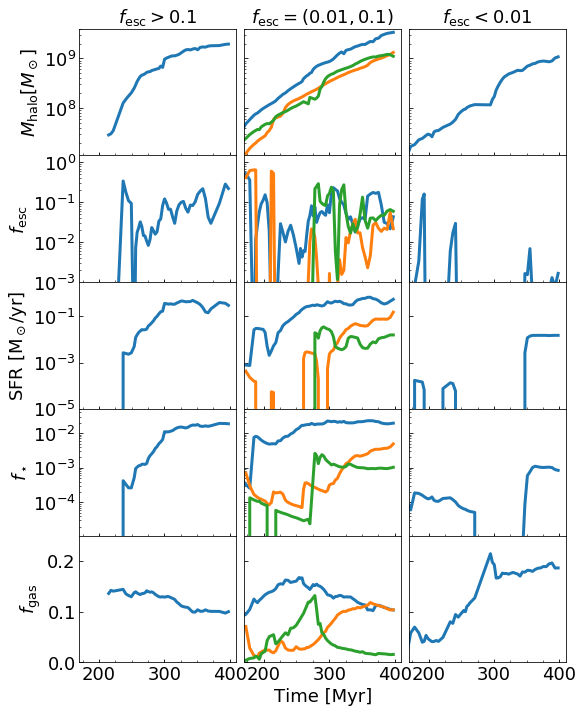

In [206]:
rc('font', size=18)
fig, ax = plt.subplots(5, 3, sharex=True, sharey=False, figsize=(8,10), squeeze=True)
plt.subplots_adjust(hspace=0, wspace=0.05, top=0.95, bottom=0.07, right=0.97)

xfield = 'time'
yfields = ['mass', 'fesc', 'SFR', 'fstar', 'fgas']
weights = [None, 'Ntot', None, None, None]

xr = (170, 410)
yr = dict(mass=(1.1e7, 4e9), fesc=(1e-3, 1.5), SFR=(1e-5, 3), fstar=(1.1e-5, 0.05), fgas=(0,0.25))
yscale = dict(mass='log', fesc='log', SFR='log', fstar='log', fgas='linear')

yfilters = [high_fesc, mid_fesc, low_fesc]
mfilter = hmach

xlabel = 'Time [Myr]'
ylabels = [r'$M_{\rm halo} [M_\odot]$', r'$f_{\rm esc}$', r'SFR [M$_\odot$/yr]', 
           r'$f_\star$', r'$f_{\rm gas}$']
xtitles = [r'$f_{\rm esc} > 0.1$', r'$f_{\rm esc} = (0.01,0.1)$',
           r'$f_{\rm esc} < 0.01$']

alpha = 1
lw = 3
min_mass = 1e7

for i, yf in enumerate(yfields):
    for j, yfil in enumerate(yfilters):
        fig, ax[i,j] = plot_halo_evo(data, xfield, yf, min_mass=min_mass, mfilter=mfilter, 
                                     alpha=alpha, lw=lw,
                                     yfilter=yfil, fig=fig, ax=ax[i,j])
                                     #, median_highlight=True,
                                     #mean_highlight=True, mean_weight=weights[i],
        ax[i,j].set_yscale(yscale[yf])
        ax[i,j].set_ylim(yr[yf][0], yr[yf][1])
        ax[i,j].set_xlim(xr[0], xr[1])
        ax[i,j].label_outer()
        ax[i,j].xaxis.set_major_locator(ticker.MultipleLocator(100))
        ax[i,j].xaxis.set_minor_locator(ticker.MultipleLocator(25))
    ax[i,0].set_ylabel(ylabels[i])

for j in range(ax.shape[1]):
    ax[0,j].set_title(xtitles[j], fontsize='medium')
ax[-1,1].set_xlabel(xlabel)

plt.savefig('fesc-hmach.png')
plt.savefig('fesc-hmach.pdf')
plt.show()